---

This Jupyter Notebook has been created by **Zahra Ghasemi Esfahani**, a Data Science Fellow of Insight Program, to investigate the **Satisfaction of employees based on a serey**.  

---

# Introduction

>

# Importing the libraries and setting default values

In [404]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import stats
from scipy.stats import variation
from os import listdir
from os.path import isfile, join
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import  Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.spatial import distance
import pylab
import matplotlib
import warnings

warnings.simplefilter('ignore')

# Below are the values that are set as default values for the figures in this report.  
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
sns.set(font_scale = 1.5)

%matplotlib inline 

In [405]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 150)

# Extract, Transfrom, Load (ETL) data

### Questionaire dataset

In [406]:
mypath='../data/raw/'
file_names = 'DATA TO USE warehouse_03_14_20 for Zahra.csv'
file = mypath+file_names
df=pd.read_csv(file)

In [407]:
# to group the columns by their types
# df.columns.to_series().groupby(df.dtypes).groups

In [408]:
print('The dataset has {} columns and {} rows.'.format(df.shape[1],df.shape[0]))

The dataset has 99 columns and 357692 rows.


In [409]:
df.head(5)

,Survey,id,participant,Survey Code,started,ti_1-resources,ti_2,ti_3,ti_4-giving extra,ti_5-ppl cooperate,...,Department Code,Department Name,Hire Date,Job Title,Region ID,Region Name,State,Sub-team,Supervisor Name,Team
0,1,103695,345311,43233,True,4,5,3,1,3,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
1,1,103453,345291,90973,True,5,5,5,5,5,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
2,1,114433,345282,15724,True,0,0,0,0,0,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
3,1,110803,345297,84210,True,5,5,5,4,4,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
4,1,112815,345272,75834,True,4,5,4,4,4,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN


In [410]:
# rename the columns' names and remove the text that accompany some of the columns' names
clp = df.columns.str.extract("(\S{2}_\d{1,})")
dict(zip(df.columns[5:65].values,clp[5:65].values[:,0]))
df.rename(columns = dict(zip(df.columns[5:65].values,clp[5:65].values[:,0])),inplace=True)

In [411]:
df['ti_Overall'] = df['ti_60']>2
df['Score'] = df['ti_positive']/(df['ti_positive']+df['ti_inconsistent']+df['ti_negative'])
df['Target'] = df['Score']>.8
df['#Responses'] = df['ti_inconsistent']+df['ti_positive']+df['ti_negative']

In [412]:
df.columns.values

array(['Survey', 'id', 'participant', 'Survey Code', 'started', 'ti_1',
       'ti_2', 'ti_3', 'ti_4', 'ti_5', 'ti_6', 'ti_7', 'ti_8', 'ti_9',
       'ti_10', 'ti_11', 'ti_12', 'ti_13', 'ti_14', 'ti_15', 'ti_16',
       'ti_17', 'ti_18', 'ti_19', 'ti_20', 'ti_21', 'ti_22', 'ti_23',
       'ti_24', 'ti_25', 'ti_26', 'ti_27', 'ti_28', 'ti_29', 'ti_30',
       'ti_31', 'ti_32', 'ti_33', 'ti_34', 'ti_35', 'ti_36', 'ti_37',
       'ti_38', 'ti_39', 'ti_40', 'ti_41', 'ti_42', 'ti_43', 'ti_44',
       'ti_45', 'ti_46', 'ti_47', 'ti_48', 'ti_49', 'ti_50', 'ti_51',
       'ti_52', 'ti_53', 'ti_54', 'ti_55', 'ti_56', 'ti_57', 'ti_58',
       'ti_59', 'ti_60', 'ti_positive', 'ti_inconsistent', 'ti_negative',
       'Tenure', 'Work Status', 'Pay Type', 'Birth Year (Range)',
       'Managerial Level', 'Confidence in Executive Team', 'Gender',
       'Race/Ethnicity', 'Meaningful Innovation Opportunities',
       'Disabilities', 'Responsibility', 'LGBT', 'Postal/Zip Code',
       'ti_unique', 'ti_ch

### The 103 columns in the above dataframe are as follows:
>  
**C0**: Index<br>
**C1**: **Survey** can be considered as the id of the organization <br>
**C2--C4**: *ignore* <br>
**C5--C64**:
**ti_1** to **ti_60**    Trusted index, 60 standard workplace questions answered on a likert 5-point scale<br>
**C61**: **ti_positive** Number of 5 and 4 responses<br>
**C62**: **ti_inconsistent** Number of 3 responses<br>
**C63**: **ti_negative** Number of 1 and 2 responses<br>
**C64--C78**: *ignore* <br>
**C79**: **Location Name**<br>
**C81**: **Department Name**<br>
**C82--C99**: *ignore* <br>
**C100**: **ti_Overall** Ranking of the workplace averall <br>
**C101**: **Score** Number of 4 and 5 responses to the number of all responses for each employee<br>
**C101**: **Target** It is 1 for scores bigger than .8 and 0 otherwise<br>
**C103**: **#Responses** Total number of responses<br>

In [413]:
df.describe()

,Survey,id,participant,ti_1,ti_2,ti_3,ti_4,ti_5,ti_6,ti_7,...,ti_56,ti_57,ti_58,ti_59,ti_60,ti_positive,ti_inconsistent,ti_negative,Score,#Responses
count,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,...,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,202722.000000,357692.000000
mean,118.952096,348566.035184,592473.881392,2.390769,2.515580,2.217399,2.218873,2.191743,2.286464,2.289313,...,2.290345,2.250685,2.187829,2.208227,2.321643,25.298746,5.189809,2.613136,0.761223,33.101691
std,64.052365,171298.507837,196470.308034,2.227446,2.305769,2.138632,2.120208,2.088734,2.175524,2.187275,...,2.189597,2.182542,2.138007,2.136333,2.230269,25.899901,9.753916,7.747756,0.291191,29.391860
min,1.000000,31.000000,50466.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,202772.750000,435831.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000
50%,122.000000,334185.500000,569923.500000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,16.000000,0.000000,0.000000,0.900000,58.000000
75%,186.000000,527634.250000,784568.250000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,...,4.000000,4.000000,4.000000,4.000000,5.000000,55.000000,6.000000,1.000000,1.000000,60.000000
max,219.000000,626424.000000,921159.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,60.000000,60.000000,60.000000,1.000000,60.000000


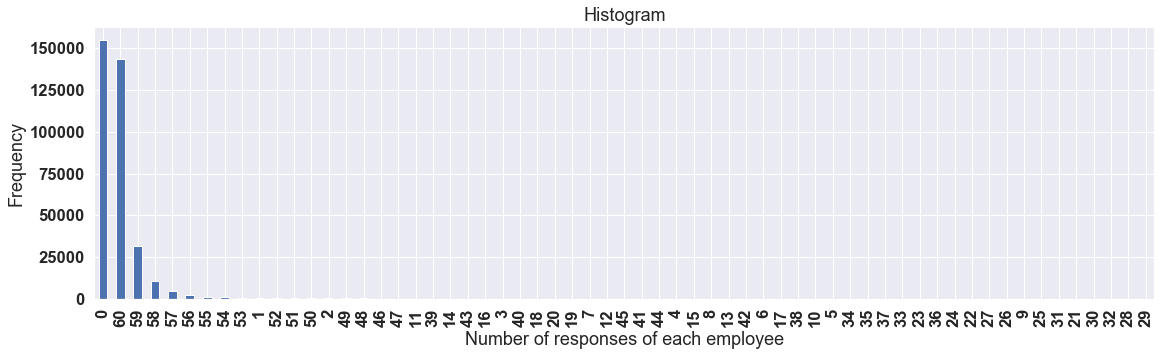

In [414]:
plt.figure(figsize=(19,5))
df['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any.

<Figure size 432x288 with 0 Axes>

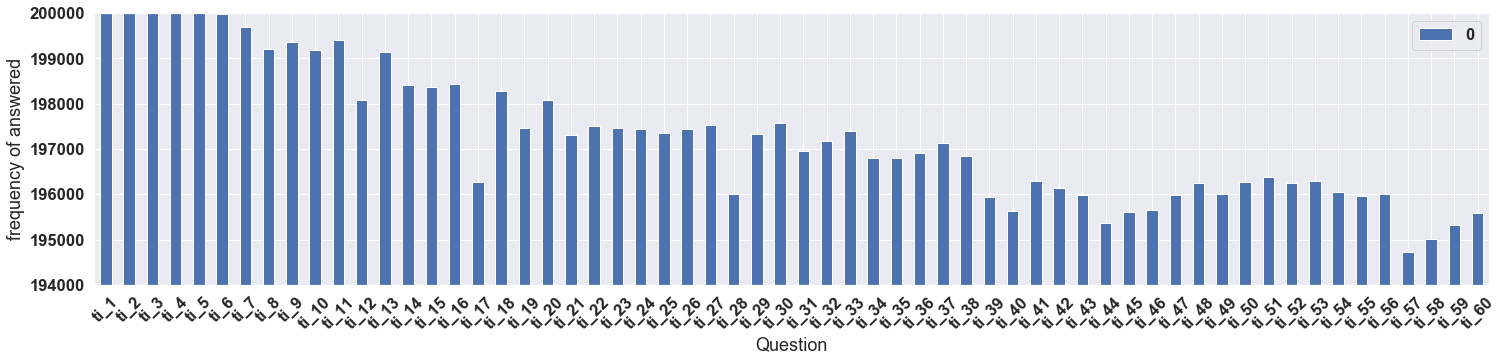

In [415]:
plt.figure()
df.astype(bool).sum(axis=0).to_frame()[5:65].plot.bar(rot=0,figsize=(25,5))
plt.xlabel('Question')
plt.ylabel('frequency of answered')
plt.ylim([194e3 , 2e5])
plt.xticks(rotation=45)
plt.show()

> This figure shows people usually left the last questions unanswered.

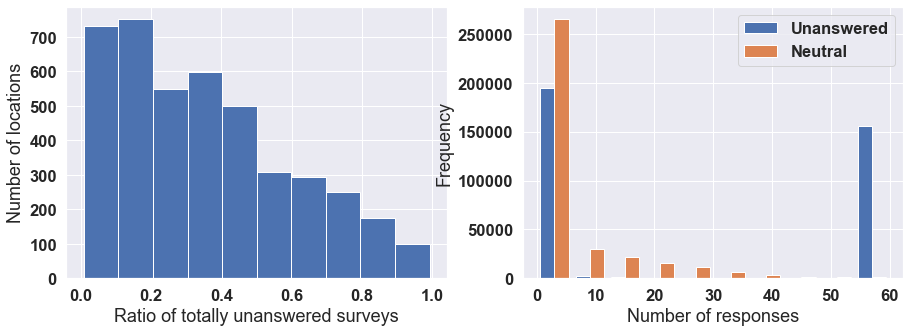

In [416]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = df[df['#Responses']==0].groupby(['Survey' , 'Location Name'])['#Responses'].count()
R = df[df['#Responses']!=0].groupby(['Survey' , 'Location Name'])['#Responses'].count()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of locations')

s0 = (60-df['#Responses'])
s3 = df['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

> **Left figure**: If we consider different locations of different organizations, we can see the ratio of unanswered questions is mostly > 0.5.<br>
**Right figure**: The mejority of people either response to all or no questions. Usually people don't choose 3 as an answer.

## Data imputation:
>  Unanswered questions:<br>
1- Can be removed<br>
2- Can be considred as neutral response 3<br>
3- Can fill in by the mod of responses<br>
4- Creating dummy features and include unanswered questions as a feature<br>

### List of manually categorized questions

In [444]:
mypath='../data/processed/'
file_names = 'Question List with Categories.xlsx'
file = mypath+file_names
dfq = pd.read_excel(file)
sheet = 'Statements in each Category'
dfq2 = pd.read_excel(file,sheet)

In [445]:
# rename the qustion tags and remove the text part
dfq['Question'] = dfq['Question'].str.extract("(\S{2}_\d{1,})")
a = dfq[['Question','Categories']].groupby('Categories').apply(lambda x: x.sort_values('Question'))
Qs = a.iloc[:,0].tolist()
dfq = dfq.merge((df[df[Qs]!=0][Qs]>3).mean().to_frame('Positive_to_Responded'),left_on='Question',right_index=True)

In [446]:
category = dfq[['Question','Categories']].groupby('Categories').size()
category

Categories
Appreciation/Recognition            7
Balancing Personal/Productivity     5
Communication/Support               9
Good incentives/growth              6
Inspiring Work                     10
Management Integrity                9
Staffing and Scheduling             3
Supplies/Systems                    4
Teamwork                            7
dtype: int64

In [447]:
meanPR = dfq.groupby('Categories')['Positive_to_Responded'].mean().sort_values()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Positive_to_Responded']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

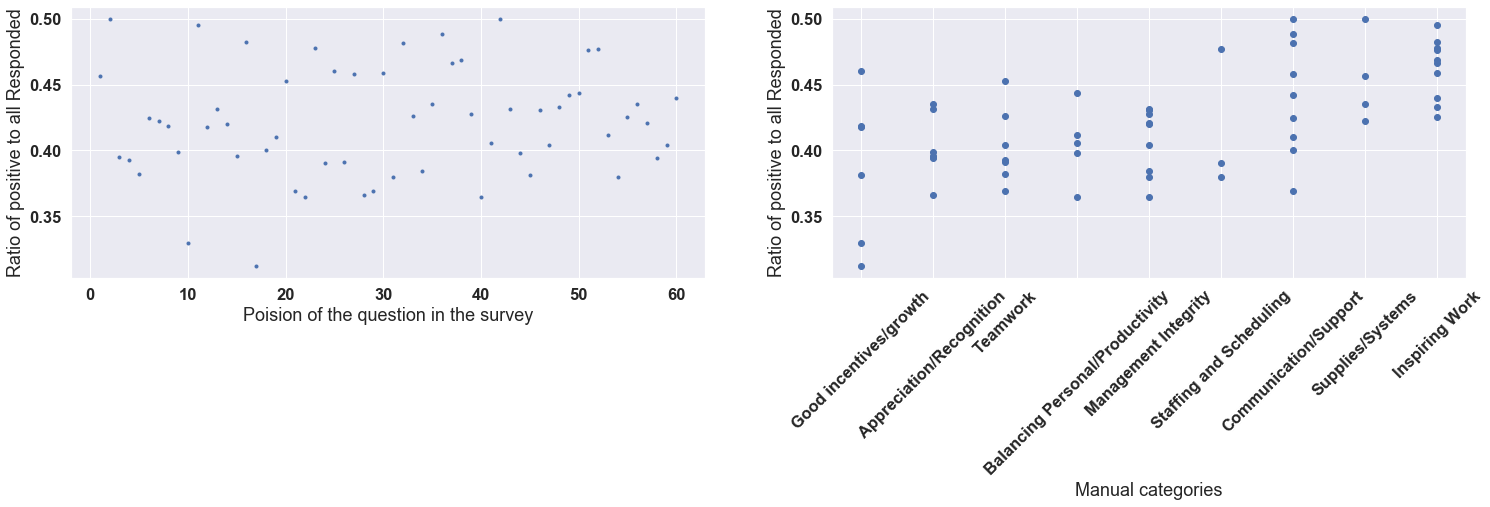

In [448]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Stmt_survey_num'],dfq['Positive_to_Responded'],'.')
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Positive_to_Responded','mean_Positive_to_Responded']].sort_values(by='mean_Positive_to_Responded')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

> **Left figure**: Score vs. Position of question in the survey. W can not se any<br>
**Right figure**: .

In [449]:
Inspiring_Work_Category =set(dfq[(dfq['Categories']=='Inspiring Work')]['Text'].index)-set([37])

In [450]:
aQs = dfq[dfq['Actionable']=='a']['Question'].values
dfq = dfq.merge((df[df[aQs]!=0][aQs]>3).mean().to_frame('Positive_to_Responded_Actionables'),left_on='Question',how='outer',right_index=True)

In [451]:
df['Actionable_Score']=(df[aQs]>3).sum(axis=1)/(df[aQs]!=0).sum(axis=1)

# Clustering the questions besed on their mutual information
> We use Mutual Information as a measure of distance between sets of responses of each question. Actually a normalized metricated variant of mutual information is an entropic Jaccard distance.

In [426]:
# It is poosible to use the 1-NMI as a measure of disctance between two sets of responses
# but mathematically it is proved that normalized metricated variant of mutual information is an entropic Jaccard distance.
# NMI = np.zeros([len(Qs),len(Qs)])
# for i in range(len(Qs)):
#     for j in range(len(Qs)):
#         NMI[i,j] = normalized_mutual_info_score(df[cl[i]],df[cl[j]])
# # indices_diagonal = np.diag_indices(len(NMI))
# # NMI[indices_diagonal] = .5
# Distance_Matrix=(1-NMI)/np.max(NMI)

In [427]:
d = distance.pdist(df[Qs].T, metric='jaccard')
Distance_Matrix = distance.squareform(d)

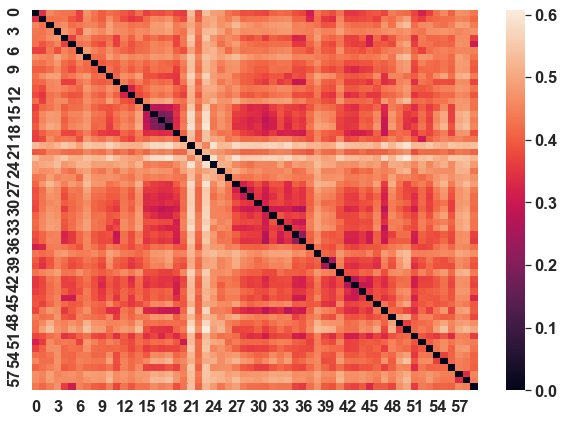

In [428]:
plt.figure(figsize=(10,7))

sns.heatmap(Distance_Matrix)
# for i in ct: 
#     plt.axhline(ct[:i].sum(),linestyle='--')
#     plt.axvline(ct[:i].sum(),linestyle='--')

In [429]:
agg = AgglomerativeClustering( affinity='precomputed', linkage = 'average')
agg.fit_predict(Distance_Matrix)
dis = squareform((Distance_Matrix).round(2))
Z = linkage(dis,method="complete")

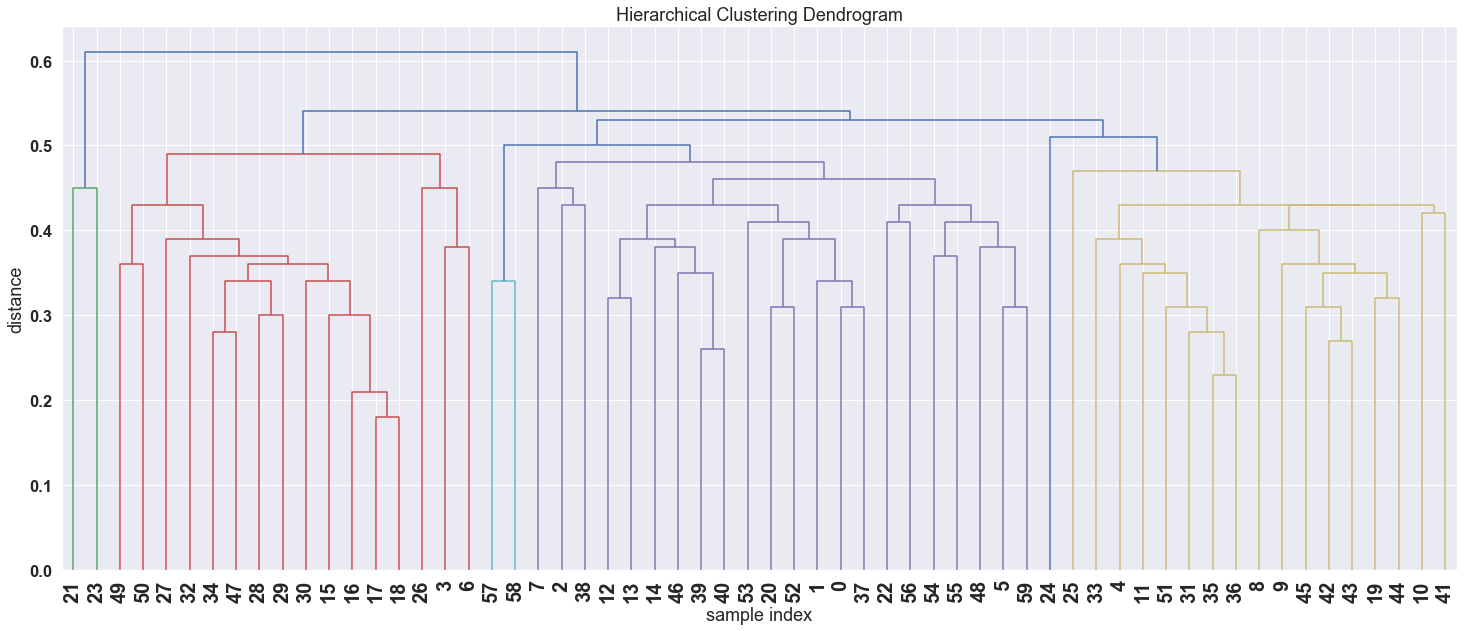

In [430]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ZZ = dendrogram(
    Z,
    color_threshold=0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [452]:
dfq.shape

(60, 8)

In [453]:
max_d = .50
clusters = fcluster(Z, max_d, criterion='distance')
dfq['Clusters'] = clusters.T
clusters

array([3, 3, 3, 2, 4, 3, 2, 3, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 4, 3, 1,
       3, 1, 5, 4, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 3, 2, 3, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

### Elbow Method

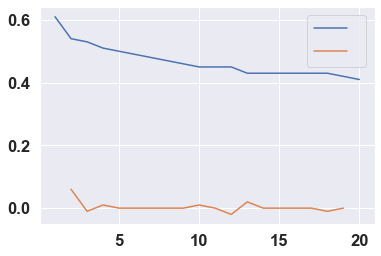

clusters: 2


In [454]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.legend(['',''])
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

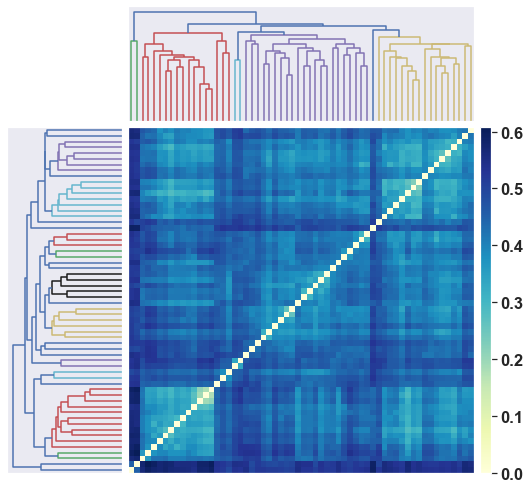

In [455]:
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))

ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Z = sch.linkage(dis, method="complete")
Z1 = dendrogram(
    Z,
    color_threshold=0.4,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    orientation='left'
)
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z = sch.linkage(dis, method="complete")
Z2 = dendrogram(
    Z,
    color_threshold=0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = Distance_Matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('dendrogram.png')

In [456]:
dfq.groupby('Clusters')['Positive_to_Responded'].mean()

Clusters
1    0.425338
2    0.408453
3    0.424864
4    0.425129
5    0.488881
Name: Positive_to_Responded, dtype: float64

In [457]:
dfq[['Clusters','Actionable','Text','Positive_to_Responded']].sort_values(by='Positive_to_Responded').sort_values(by='Clusters').head(60)

,Clusters,Actionable,Text,Positive_to_Responded
21,1,a,Management involves people in decisions that affect their jobs or work environment.,0.368876
23,1,a,People here are treated fairly regardless of their race.,0.481800
30,2,a,I feel I receive a fair share of the profits made by this organization.,0.311956
26,2,a,I am treated as a full member here regardless of my position.,0.442031
3,2,NaN,Our facilities contribute to a good working environment.,0.435201
6,2,a,"Management is approachable, easy to talk with.",0.431757
49,2,a,Management is honest and ethical in its business practices.,0.430915
47,2,a,I believe management would lay people off only as a last resort.,0.427681
16,2,NaN,People care about each other here.,0.425852
18,2,a,Management makes its expectations clear.,0.424569


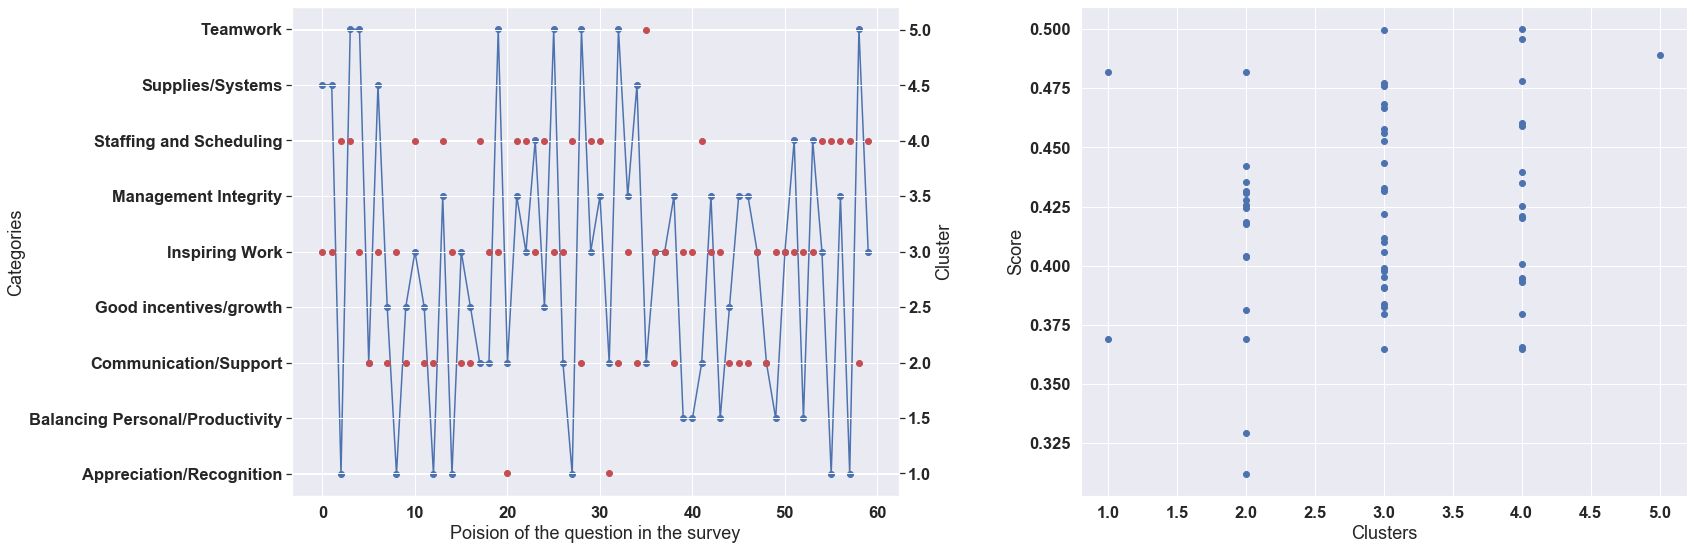

In [523]:
fig , ax = plt.subplots(1,2,figsize=(25,9))
dfq = dfq.sort_values(by='Stmt_survey_num')
x= np.arange(60)
y = label_encoder.fit_transform(dfq['Categories'])

ax[0].plot(x,y,color='b',marker='o')
ax[0].set_yticks(np.arange(len(dfq['Categories'].unique())))
ax[0].set_yticklabels(sorted(dfq['Categories'].unique()))
# ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Categories')
ax0 = ax[0].twinx()
ax0.scatter(x,dfq['Clusters'],color='r',marker='o')
ax0.set_ylabel('Cluster')

PR_Catg = dfq[['Clusters','Positive_to_Responded']].sort_values(by='Clusters')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Score')
# ax[1].set_ylabel('Ratio of positive to all Responded questions')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace=.3)
plt.show()

## Target variable

In [ ]:
# fig , ax = plt.subplots(2,6,figsize=(35,5),sharex=True,sharey=True)

# for i in range(6):
#     sns.barplot(x=Qs, y=df[df['ti_60']==i][Qs].mean(),ax=ax[0,i])
#     sns.barplot(x=Qs, y=df[(df['Score']<=(i)*.2) & (df['Score']>(i-1)*.2)][Qs].mean(),ax=ax[1,i])

In [472]:
perc = df['#Responses'].value_counts()[0]/df['#Responses'].value_counts().sum()*100
print('{}% of employees have not left the entire survay blank.'.format(int(perc)))
perc = df['#Responses'].value_counts()[2:].sum()/df['#Responses'].value_counts().sum()*100
print('{}% of employees have not compeleted the entire survay.'.format(int(perc)))

43% of employees have not left the entire survay blank.
16% of employees have not compeleted the entire survay.


Text(0, 0.5, 'Score')

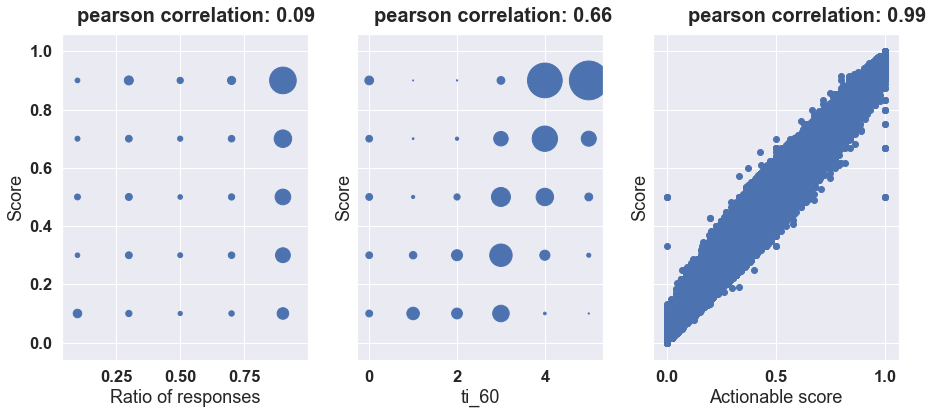

In [518]:
fig , ax = plt.subplots(1,3,figsize=(15,6),sharex=False,sharey=True)
X = (df['#Responses']/60).copy()
Y = (df['Score']).copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) ,.2)+.1
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X)+.2 ,.2) -.05
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X, Y, bins=(xedges, yedges))
ax[0].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/5)
ax[0].text(0.1,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[0].set_xlabel('Ratio of responses')
ax[0].set_ylabel('Score')

X = df['ti_60'].copy()
Y = df['Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[1].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/20)
ax[1].text(0.1,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[1].set_xlabel('ti_60')
ax[1].set_ylabel('Score')

X = df['Actionable_Score'].copy()
Y = df['Score'].copy()
X = X[~np.isnan(X) & ~np.isnan(Y)]
Y = Y[~np.isnan(X) & ~np.isnan(Y)]

ax[2].scatter(X,Y)
ax[2].text(0.1,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[2].set_xlabel('Actionable score')
ax[2].set_ylabel('Score')
